In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as spstats
import torch

import hyclib as lib
from hyclib.sp import stats

In [3]:
lib.logging.basic_config()
logging.captureWarnings(True) 
logger = logging.getLogger(__name__)

In [29]:
M, N, D = 100, 100000, 2
bins = (10,20)

arr = np.random.normal(size=(N,D))
indices_0 = np.random.randint(N, size=M)
indices_1 = np.random.randint(D, size=M)
arr[indices_0, indices_1] = np.nan
t = torch.from_numpy(arr)

In [30]:
%%timeit
lib.sp.stats.bin_dd(arr, bins=bins, nan_policy='omit')

10.6 ms ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%%timeit
lib.pt.stats.bin_dd(t, bins=bins, nan_policy='omit')

  torch.bucketize(sample[:, i], edges[i], right=True) # `right` argument has opposite meaning in torch.bucketize vs np.digitize



2.25 ms ± 92.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
%%timeit
for i in range(D):
    lib.sp.stats.bin(arr[:, i], bins=bins[i], nan_policy='omit')

8.06 ms ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%%timeit
for i in range(D):
    lib.pt.stats.bin(t[:, i], bins=bins[i], nan_policy='omit')

2.22 ms ± 4.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [189]:
M, N, O = 100000, 1000000, 1000
x = np.random.randint(M, size=N).astype(float)
y = np.random.randint(M, size=N).astype(float)
nan_x = np.random.randint(N, size=O)
nan_y = np.random.randint(N, size=O)
x[nan_x] = np.nan
y[nan_y] = np.nan
z = np.stack([x,y], axis=1)

In [143]:
def unique_1(z):
    return np.unique(z, axis=0)

def unique_2(z):
    x, y = z[:,0], z[:,1]
    ux, x_inv = np.unique(x, return_inverse=True)
    uy, y_inv = np.unique(y, return_inverse=True)
    x_dtype = np.min_scalar_type(x_inv.max())
    y_dtype = np.min_scalar_type(y_inv.max())
    dtype = np.result_type(x_dtype, y_dtype)
    nbytes = dtype.itemsize
    dtype = np.dtype(f'u{2 * nbytes}')
    x_inv, y_inv = x_inv.astype(dtype), y_inv.astype(dtype)
    xy = (x_inv << (nbytes * 8)) + y_inv
    _, idx = np.unique(xy, return_index=True)
    return np.stack([ux[x_inv[idx]], uy[y_inv[idx]]], axis=1)

In [144]:
%timeit unique_1(z)
%timeit unique_2(z)
%timeit lib.np.unique_rows(z)

803 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
389 ms ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
782 ms ± 7.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [137]:
unique_2(z)

array([[0.000e+00, 7.939e+03],
       [2.000e+00, 6.190e+02],
       [3.000e+00, 4.974e+03],
       ...,
       [      nan, 9.374e+03],
       [      nan, 9.543e+03],
       [      nan,       nan]])

In [136]:
lib.np.unique_rows(z)

array([[0.000e+00, 7.939e+03],
       [2.000e+00, 6.190e+02],
       [3.000e+00, 4.974e+03],
       ...,
       [      nan, 9.374e+03],
       [      nan, 9.543e+03],
       [      nan,       nan]])

In [10]:
spstats.binned_statistic([1,2,3,4,5,6], [0,1,2,3,4,5], bins=[4,2,0])

ValueError: cannot convert float NaN to integer

{'x': array([ 0.47368421,  1.42105263,  2.36842105,  3.31578947,  4.26315789,
        5.21052632,  6.15789474,  7.10526316,  8.05263158,  9.        ,
        9.94736842, 10.89473684, 11.84210526, 12.78947368, 13.73684211,
       14.68421053, 15.63157895, 16.57894737, 17.52631579]), 'y': array([-0.01408797, -0.0227798 ,  0.00175112,  0.03305718,  0.0978829 ,
        0.04776662,  0.08029443,  0.06956061,  0.33476553, -0.06137414,
       -0.07059   , -0.10609316, -0.02900036, -0.0187883 , -0.0584314 ,
       -0.02033019,  0.05125035, -0.02552311, -0.01305337]), 'yerr': array([0.00411313, 0.00252236, 0.02032855, 0.00049519, 0.01195727,
       0.00516345, 0.0079559 , 0.01241825, 0.00187416, 0.01666851,
       0.03017907, 0.01228739, 0.01832908, 0.02207788, 0.0064688 ,
       0.01349114, 0.00602944, 0.00686532, 0.01387614])}


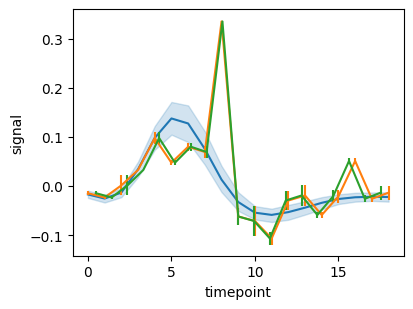

In [4]:
df = sns.load_dataset('fmri')
signal_err = np.abs(np.random.normal(size=len(df['signal'])))
signal_err[np.arange(100)] = np.nan
df['signal_err'] = signal_err
# print(df['timepoint'])
sns.lineplot(df, x='timepoint', y='signal')
lib.plot.lineplot(df, x='timepoint', y='signal', yerr='signal_err', weighted=True)

result = stats.binned_mean(df['timepoint'], df['signal'], df['signal_err'], bins=len(df['timepoint'].unique()), weighted=True)
print(result)
plt.errorbar(**result)
plt.show()

In [38]:
x = np.array([-1,0,1,1,2,3,5,7,9,10,5,7,3,2,4,4])
y = np.array([-1,0,1,1,2,3,5,7,9,10,5,7,3,2,4,4])
bins = (2,5)
sample = np.array([x,y]).T
print(sample.shape)
bin_nums, centers, edges = lib.sp.stats.digitize_dd(sample, bins)
print(bin_nums)
print(bin_nums.shape)
print(centers)
print(edges)
print(centers[0][bin_nums[0]])
print(centers[1][bin_nums[1]])

(16, 2)
[[1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1]
 [1 1 1 1 2 2 3 4 5 5 3 4 2 2 3 3]]
(2, 16)
[array([ nan, 1.75, 7.25,  nan]), array([nan, 0.1, 2.3, 4.5, 6.7, 8.9, nan])]
[array([-1. ,  4.5, 10. ]), array([-1. ,  1.2,  3.4,  5.6,  7.8, 10. ])]
[1.75 1.75 1.75 1.75 1.75 1.75 7.25 7.25 7.25 7.25 7.25 7.25 1.75 1.75
 1.75 1.75]
[0.1 0.1 0.1 0.1 2.3 2.3 4.5 6.7 8.9 8.9 4.5 6.7 2.3 2.3 4.5 4.5]
